# Introduction

Predicting loan approval is an important problem in consumer facing finance. Bank lenders can receieve thousands to hundreds of thousands of applications from individuals with a wide variety of financial variables, leading to the necessity for automation of these loan approval processes. 
Approving loans which end up defaulting can increase financial risk, while being too conservative in lending loans can reduce business opportunity and leave valuable profits to waste. As a way to reduce these errors in the automated loan approval process, organizations rely on data driven methods and algorithms to get a better understanding of loan approval factors. 

In this project, we will explore a synthetic loan approval dataset and identify key drivers behind approval decisions, allowing us to build a predictive machine learning model to accurately determine a loan applications approval status. 

# Adding Directory For Plots

In [1]:
import os
os.makedirs("plots", exist_ok=True)

# Data Description

The dataset contains information on thousands of past loan applications, each row repesenting an individual applicant, with a mix of variables that may be related to loan approval status.

This data contains 20 features (1 id, 1 target), a distribution of 55/45 in target status, and includes real world financial approval logic (DTI ratios, Filed Defaults, etc...)  


This dataset provides a healthy combination of demographic, financial, and credit related information, making it suitable for understanding patterns in loan approvals. Before modeling, we will clean the dataset, address missing values, check for outliers, and explore some potential relationships between key features and loan outcomes.

# Data Processing and Exploration

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
df = pd.read_csv("data/Loan_approval_data_2025.csv")
df.head(5)

,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
0,CUST100000,40,Employed,17.2,25579,692,5.3,895,10820,0,0,0,Credit Card,Business,600,17.02,0.423,0.023,0.008,1
1,CUST100001,33,Employed,7.3,43087,627,3.5,169,16550,0,1,0,Personal Loan,Home Improvement,53300,14.10,0.384,1.237,0.412,0
2,CUST100002,42,Student,1.1,20840,689,8.4,17,7852,0,0,0,Credit Card,Debt Consolidation,2100,18.33,0.377,0.101,0.034,1
3,CUST100003,53,Student,0.5,29147,692,9.8,1480,11603,0,1,0,Credit Card,Business,2900,18.74,0.398,0.099,0.033,1
4,CUST100004,32,Employed,12.5,63657,630,7.2,209,12424,0,0,0,Personal Loan,Education,99600,13.92,0.195,1.565,0.522,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              50000 non-null  object 
 1   age                      50000 non-null  int64  
 2   occupation_status        50000 non-null  object 
 3   years_employed           50000 non-null  float64
 4   annual_income            50000 non-null  int64  
 5   credit_score             50000 non-null  int64  
 6   credit_history_years     50000 non-null  float64
 7   savings_assets           50000 non-null  int64  
 8   current_debt             50000 non-null  int64  
 9   defaults_on_file         50000 non-null  int64  
 10  delinquencies_last_2yrs  50000 non-null  int64  
 11  derogatory_marks         50000 non-null  int64  
 12  product_type             50000 non-null  object 
 13  loan_intent              50000 non-null  object 
 14  loan_amount           

In [5]:
df = df.drop('customer_id', axis=1)


## Basic EDA

### Target Variable Balance

In [6]:
df["loan_status"].value_counts().reset_index()

,loan_status,count
0,1,27523
1,0,22477


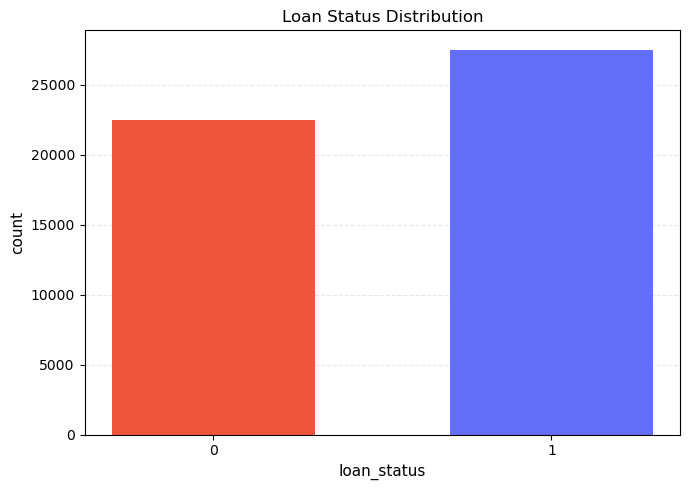

In [7]:
# Get value counts
loan_counts = df["loan_status"].value_counts().sort_index()

# Create the figure
fig, ax = plt.subplots(figsize=(7, 5))

# Create bar plot
ax.bar(loan_counts.index, loan_counts.values, 
       color=['#EF553B', '#636EFA'],  # Red and blue to match Plotly colors
       width=0.6)

# Customize
ax.set_xlabel('loan_status', fontsize=11)
ax.set_ylabel('count', fontsize=11)
ax.set_title('Loan Status Distribution', fontsize=12)
ax.set_xticks([0, 1])

# Optional: add gridlines for easier reading
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig("plots/loan_status_distribution.png")
plt.show()

### Univariate EDA for numerical columns

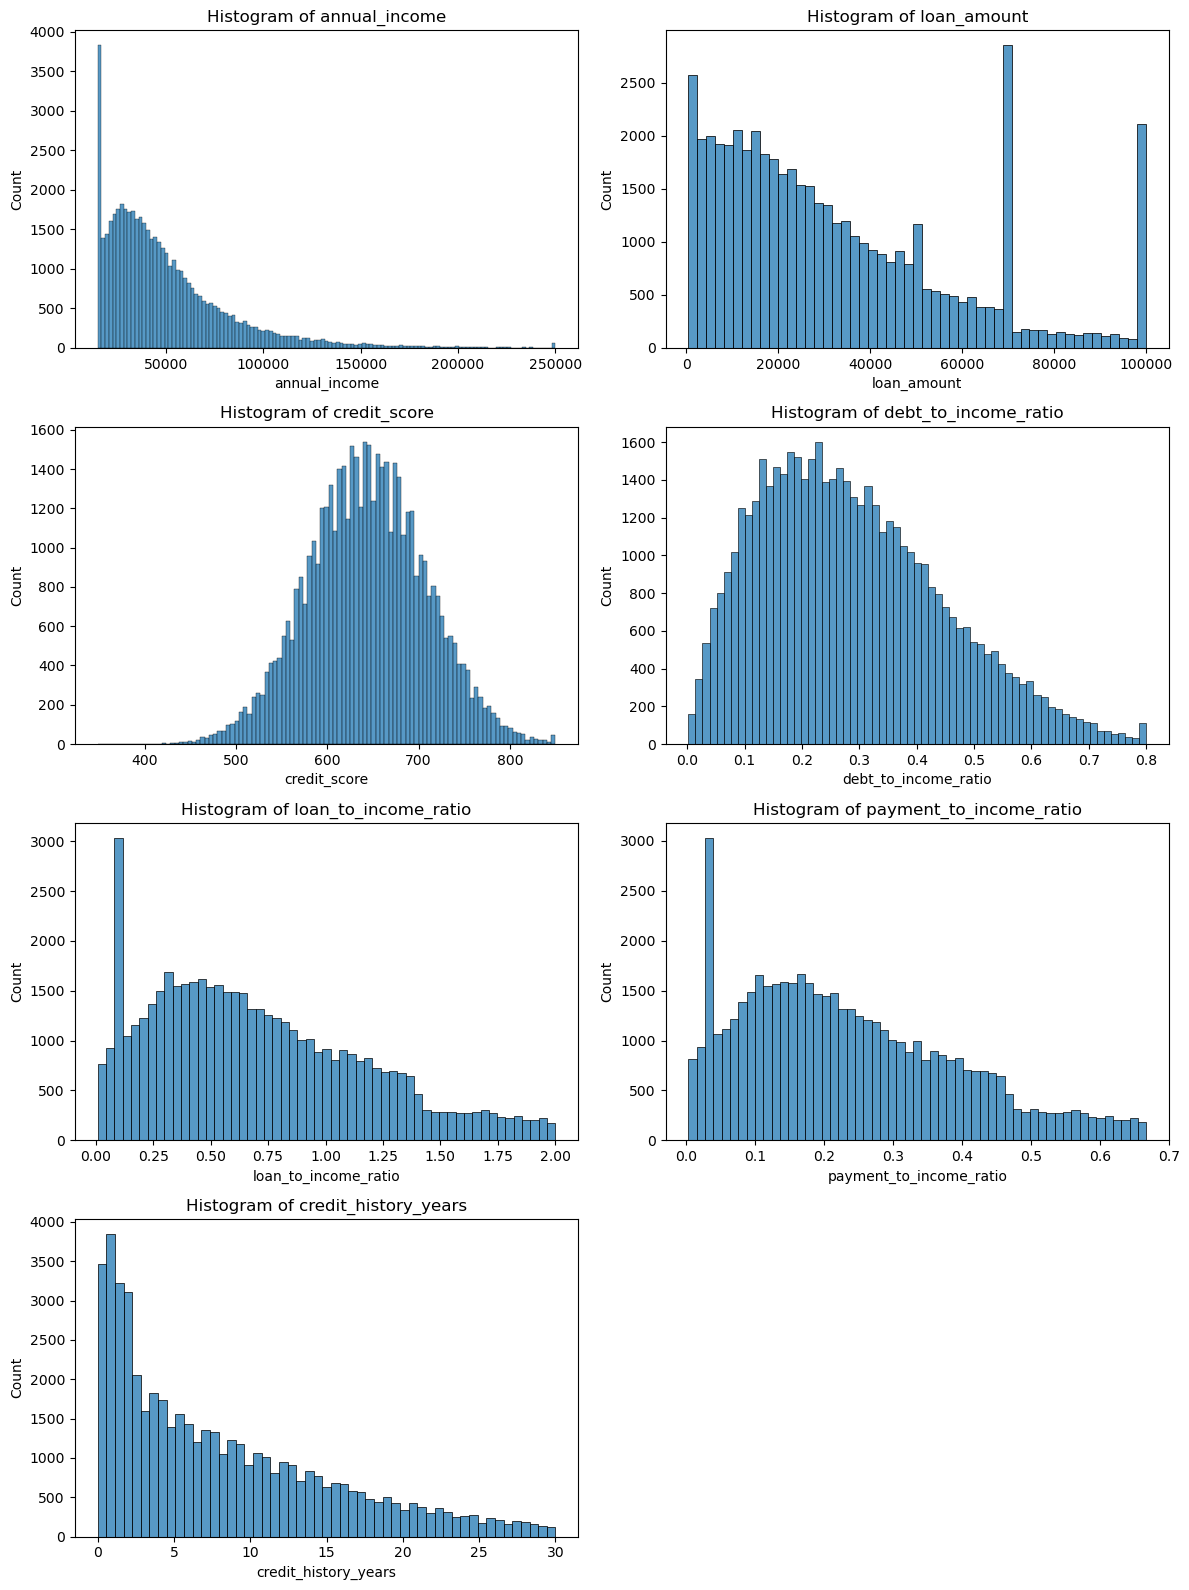

In [8]:
num_col = ["annual_income", "loan_amount", "credit_score", 
           "debt_to_income_ratio", "loan_to_income_ratio",
           "payment_to_income_ratio", "credit_history_years"]

n = len(num_col)
rows = (n + 1) // 2
plt.figure(figsize=(12, rows * 4))

for i, col in enumerate(num_col, 1):
    plt.subplot(rows, 2, i)
    sns.histplot(df[col])
    plt.title(f"Histogram of {col}")
    plt.savefig(f"plots/{col}_histogram.png")

plt.tight_layout()
plt.show()

### Correlation Heatmap

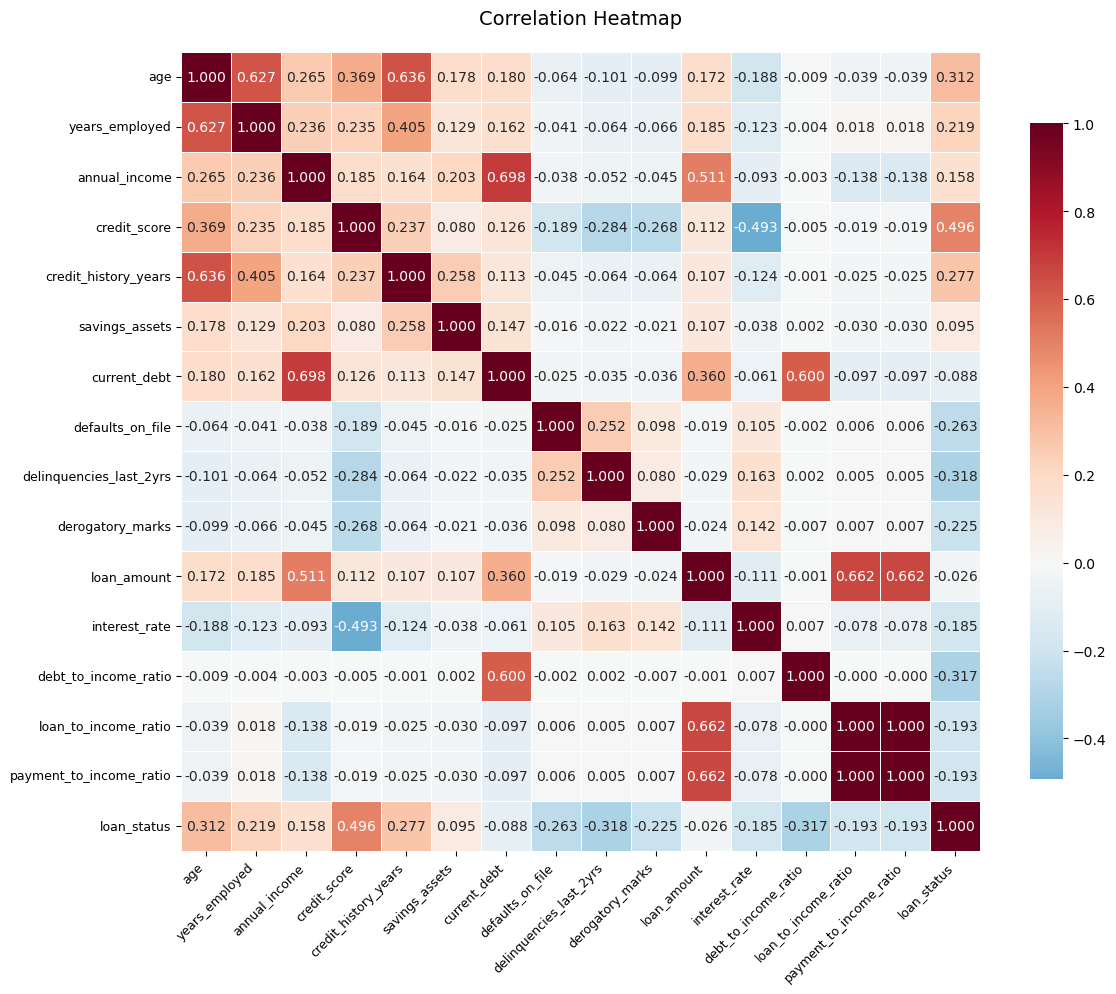

In [9]:
numeric_df = df.select_dtypes(include="number")

corr = numeric_df.corr()

fig, ax = plt.subplots(figsize=(12, 10))

# Create heatmap
sns.heatmap(corr, 
            annot=True,  # Show correlation values
            fmt='.3f',   # Format to 2 decimal places
            cmap='RdBu_r',  # Red-Blue reversed colormap
            center=0,    # Center colormap at 0
            square=True, # Make cells square
            linewidths=0.5,  # Add gridlines
            cbar_kws={"shrink": 0.8},
            ax=ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.set_title('Correlation Heatmap', fontsize=14, pad=20)

plt.tight_layout()
plt.savefig("plots/correlation_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()


### Bivariate Analysis

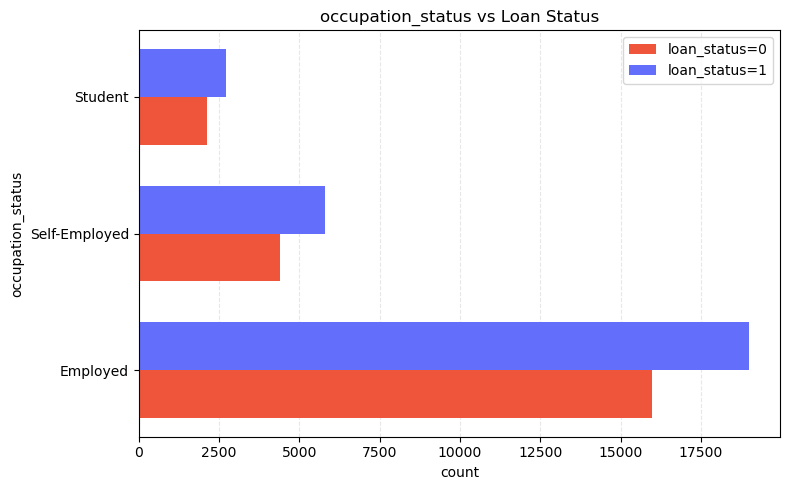

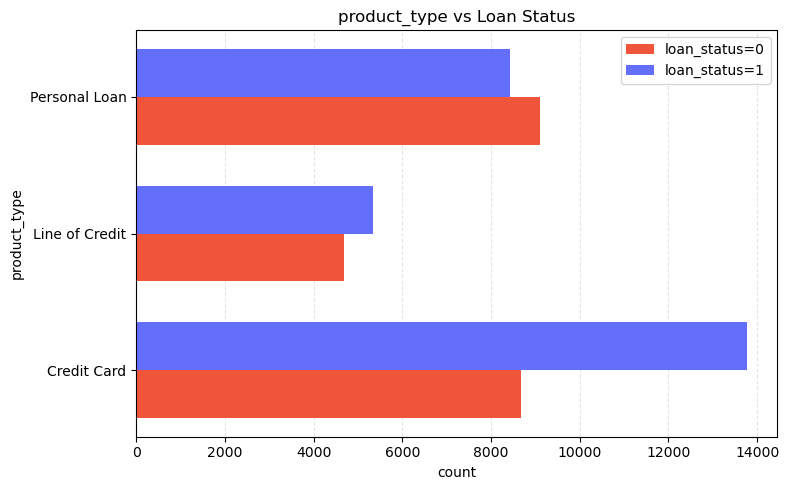

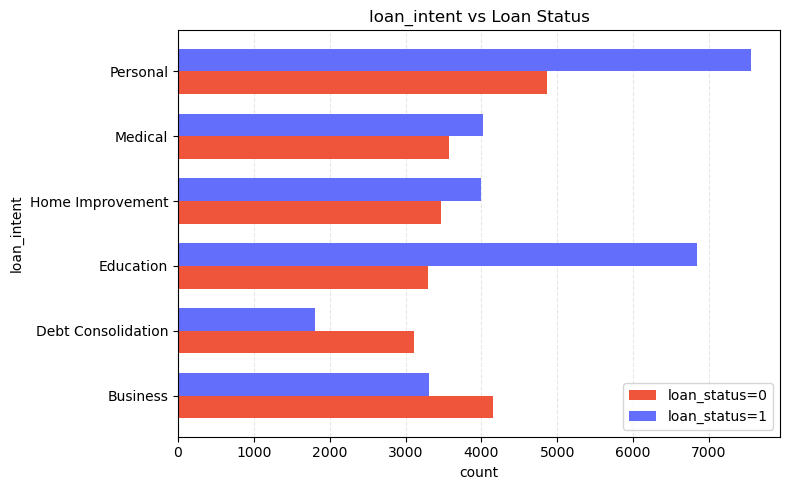

In [10]:
import matplotlib.pyplot as plt

categorical_cols = ['occupation_status', 'product_type', 'loan_intent']

for col in categorical_cols:
    # Get value counts for each loan status
    counts_0 = df[df['loan_status'] == 0][col].value_counts().sort_index()
    counts_1 = df[df['loan_status'] == 1][col].value_counts().sort_index()
    
    # Initializing figure to plot on
    fig, ax = plt.subplots(figsize=(8, 5))
    
    # Bar position configuration
    categories = sorted(df[col].unique())
    x = range(len(categories))
    width = 0.35
    
    # Bars per group
    ax.barh([i - width/2 for i in x], 
            [counts_0.get(cat, 0) for cat in categories],
            width, label='loan_status=0', color='#EF553B')
    ax.barh([i + width/2 for i in x], 
            [counts_1.get(cat, 0) for cat in categories],
            width, label='loan_status=1', color='#636EFA')

    # Axis configuration
    ax.set_yticks(x)
    ax.set_yticklabels(categories)
    ax.set_xlabel('count')
    ax.set_ylabel(col)
    ax.set_title(f"{col} vs Loan Status")
    ax.legend()
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig(f"plots/{col}_vs_loan_status.png", dpi=150, bbox_inches='tight')
    plt.show()

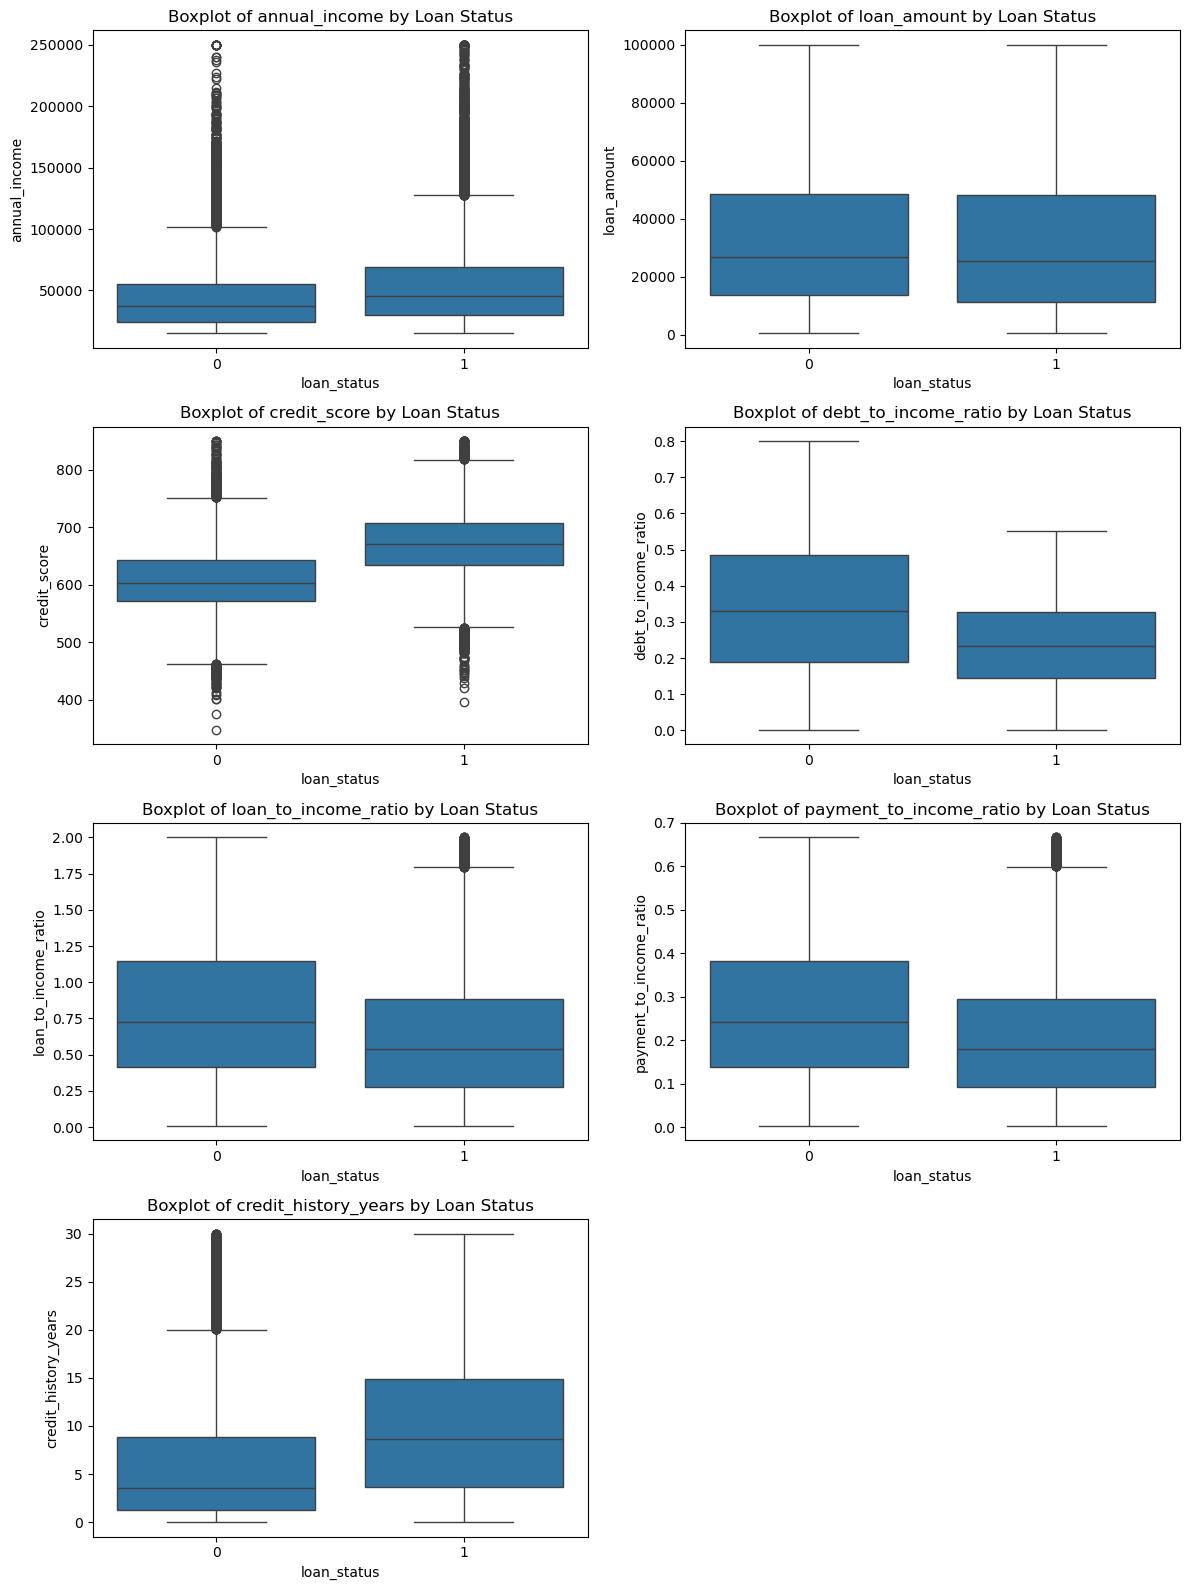

In [11]:
n = len(num_col)
rows = (n + 1) // 2

plt.figure(figsize=(12, rows * 4))

for i, col in enumerate(num_col, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=df['loan_status'], y=df[col])
    plt.title(f"Boxplot of {col} by Loan Status")
    plt.savefig(f"plots/{col}_boxplot.png")

plt.tight_layout()
plt.show()


In [12]:
average_ratios = df.groupby("loan_status")[num_col].median().T
average_ratios

loan_status,0,1
annual_income,37127.000,45708.000
loan_amount,26900.000,25400.000
credit_score,603.000,671.000
debt_to_income_ratio,0.329,0.232
loan_to_income_ratio,0.726,0.539
payment_to_income_ratio,0.242,0.180
credit_history_years,3.600,8.600


## Insight from EDA

Some details and insights that may be useful or interesting gathered from this exploratory data analysis.

- Most approved lendee's are on average older, longer employed, and higher credit score
- Most approved lendee's have lower debt
- Most approved lendee's have a better DTI, LTI, and PTI ratio (lower = better)
- Credit card loans on average have a higher rate of denial
- Credit history on average approved lendee's is 2x higher than those denied
  

Here we will convert our cleaned data into a csv for model training and evaluation:

In [13]:
df.to_csv('data/cleaned_data.csv', index=False)